# Overview

This notebook fits the naive algorithm on the Danube and its subset, as well as segments of the Lower Colorado, and compare them to the results obtained by QTree. 

The accompanying discussion can be found in the paper 

**"THE TROPICAL GEOMETRY OF CAUSAL INFERENCE FOR
EXTREMES"** by Ngoc Tran (arxiv number will be updated soon)

In [1]:
import networkx as nx
import pickle
import os
from qtreeAutoSelect import generateSubsamples, qtreeAutoSelect,saveScores
import utils as utils
import matplotlib.pyplot as plt     
import seaborn as sns
from plotCodes import plotComparison       


### Fitting on all of the Danube with pairwise correlation

In [2]:
river = 'danube'
data_file = os.path.join('data',river,'data.pk')
with open(data_file, 'rb') as file_name:
    df,labels,G_true = pickle.load(file_name)                  

G_true = nx.DiGraph(G_true)


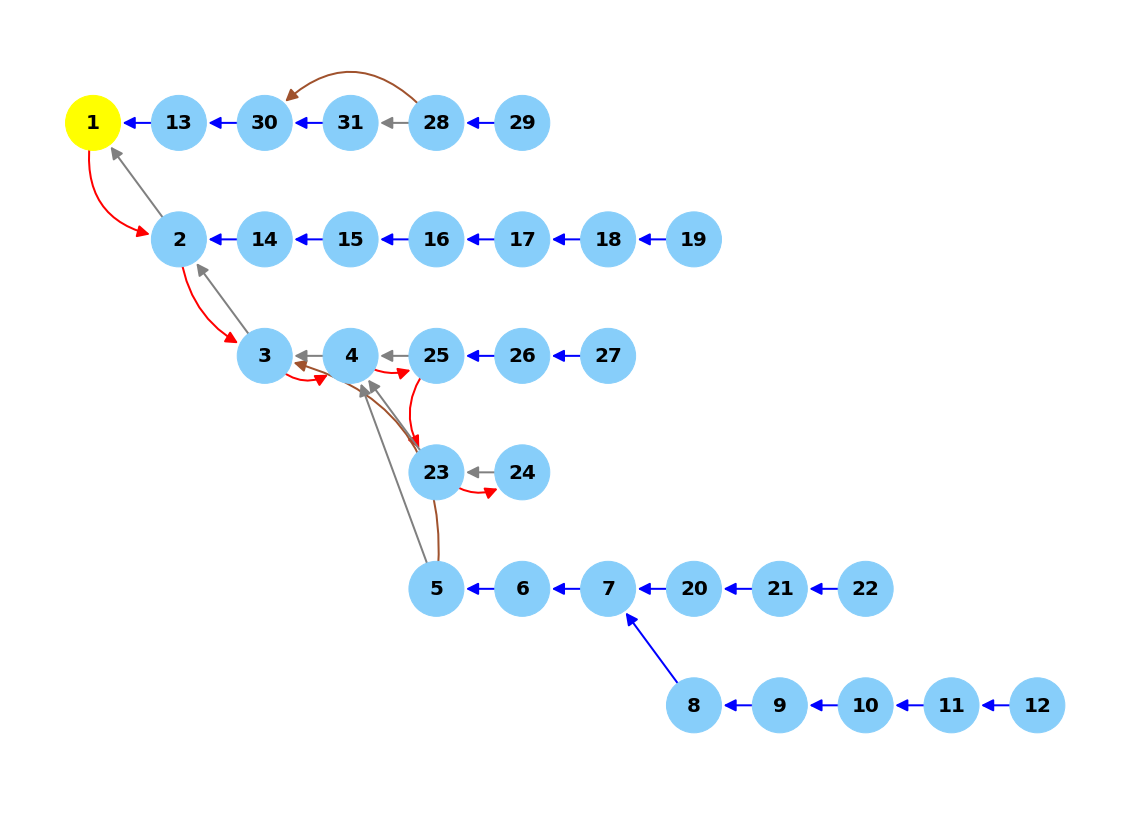

In [4]:
corr_mat = df.corr()

T = utils.spanTree(corr_mat, isMin=False)

tree = nx.relabel_nodes(T,labels)

G_true_labeled = nx.relabel_nodes(nx.DiGraph(G_true),labels)


import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 15]
plotComparison(tree, G_true_labeled,nodesize=20)

In [5]:
# compute performance statistics
G_true_mat =  utils.getSupport(G_true_labeled)
G_est_mat = utils.getSupport(tree)
utils._count_accuracy(G_true_mat,G_est_mat)

{'fdr': 0.26666666666666666,
 'tpr': 0.7333333333333333,
 'fpr': 0.01839080459770115,
 'shd': 0.18333333333333332}

#### Fitting on the same subset of the Danube as Gnecco et al

Reference paper: 
*Nicola Gnecco, Nicolai Meinshausen, Jonas Peters, and Sebastian Engelke*. Causal discovery
in heavy-tailed models

In [10]:
# map written labels on the river to columns of the dataframe
labels_reverse = dict([(labels[key],key) for key in labels])

In [11]:
import numpy as np
subnodes_labels = [str(x) for x in (23, 26, 28, 19, 21, 11, 9, 7, 14, 13, 1)]
subnodes_index = [labels_reverse[i] for i in subnodes_labels]

In [12]:
# compute the subtree of the true river restricted to these nodes
tree_true = G_true_labeled.subgraph(subnodes_labels).copy()
tree_true.add_edges_from([('11','9'), ('19','14'), ('21','7'), ('9','7'), ('7','1'), ('23','1'), ('14','1'), ('26','1'), ('28','13')])

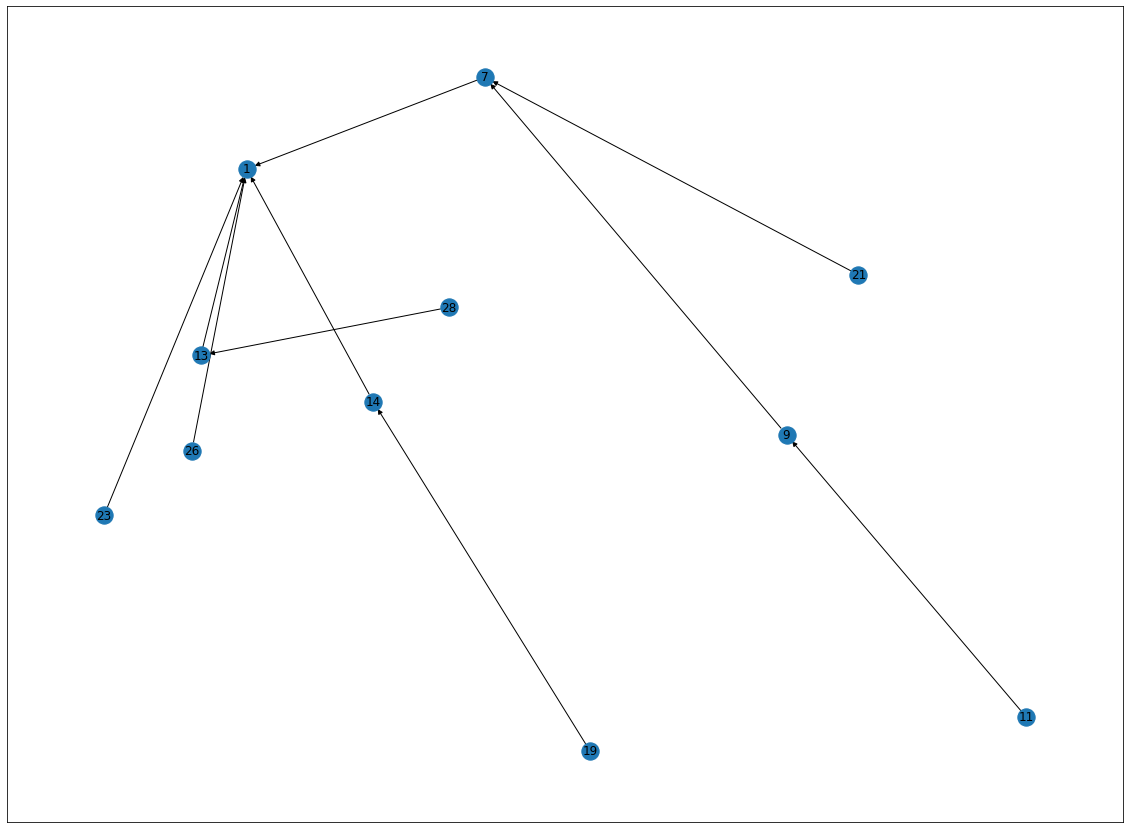

In [13]:
# confirm that we correctly defined the tree
nx.draw_networkx(tree_true)

In [14]:
#compute the estimated tree
df_small = df[subnodes_index]
corr_mat = df_small.corr()
T = utils.spanTree(corr_mat, isMin=False)
tree = nx.relabel_nodes(T, labels)

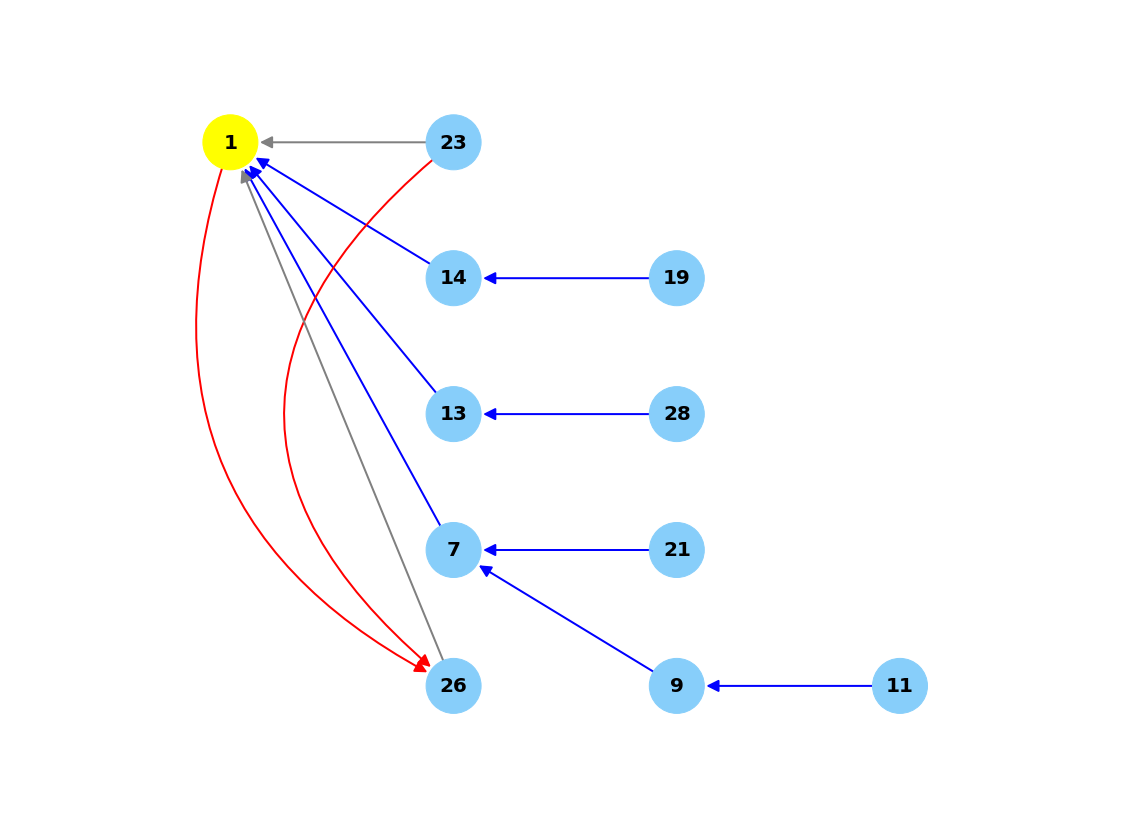

In [15]:
#plot comparison
plotComparison(tree,tree_true,nodesize=20)

### Learning the Upper and Middle Colorado with the naive algorithm

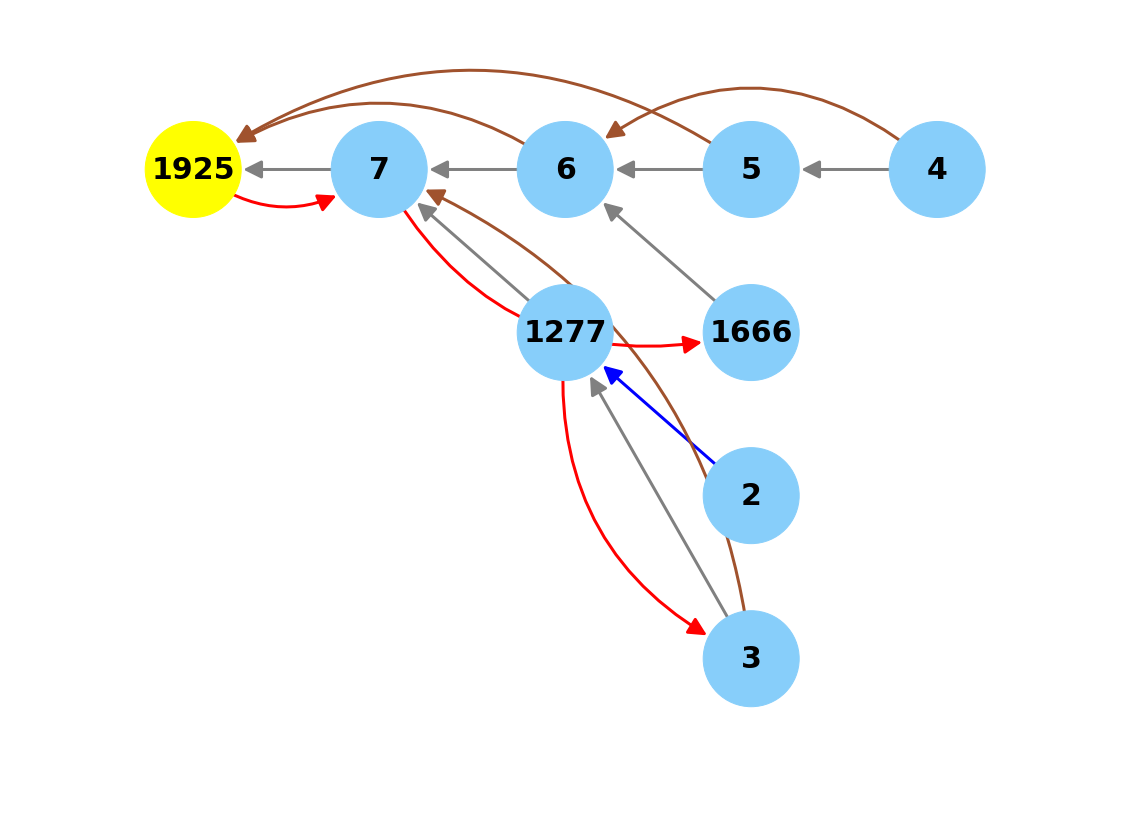

In [17]:
river = 'upper-colorado'
data_file = os.path.join('data',river,'data.pk')
with open(data_file, 'rb') as file_name:
    df,labels,G_true = pickle.load(file_name)                  

G_true = nx.DiGraph(G_true)

corr_mat = df.corr()

T = utils.spanTree(corr_mat, isMin=False)

tree = nx.relabel_nodes(T,labels)

G_true_labeled = nx.relabel_nodes(nx.DiGraph(G_true),labels)


import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 15]
plotComparison(tree, G_true_labeled,nodesize=30)

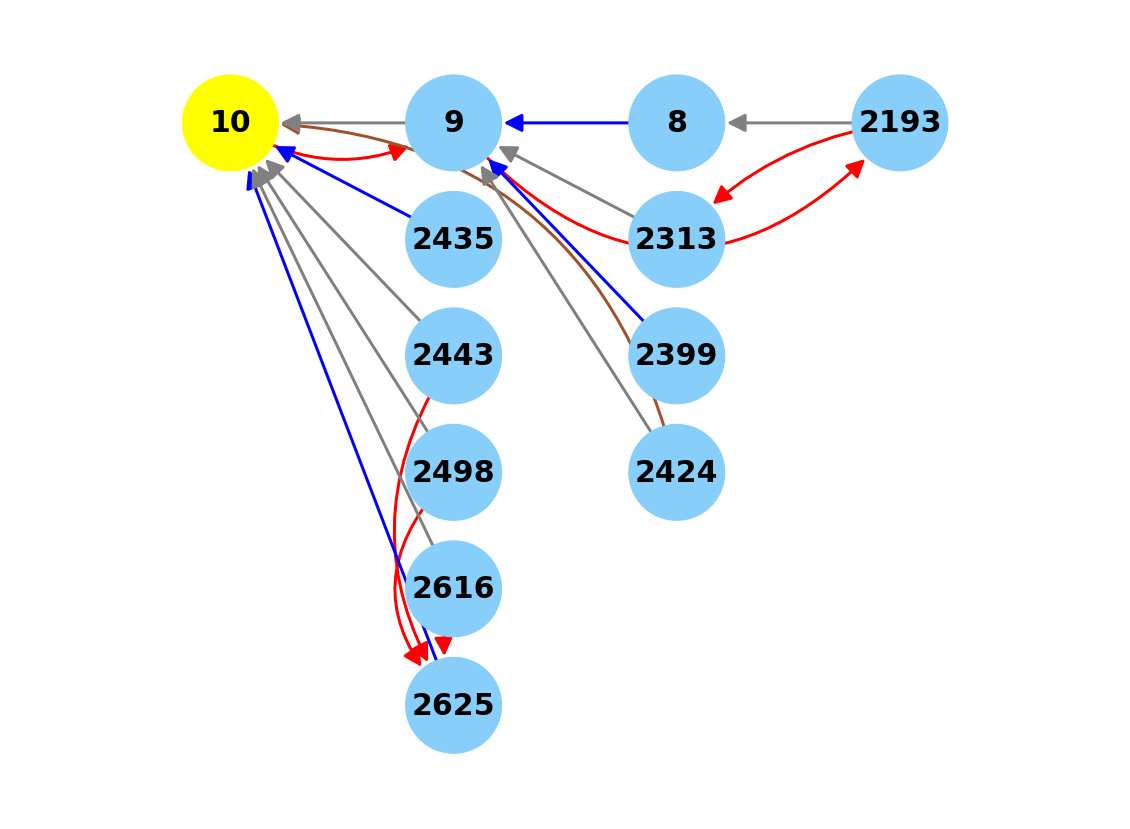

In [16]:
river = 'middle-colorado'
data_file = os.path.join('data',river,'data.pk')
with open(data_file, 'rb') as file_name:
    df,labels,G_true = pickle.load(file_name)                  

G_true = nx.DiGraph(G_true)

corr_mat = df.corr()

T = utils.spanTree(corr_mat, isMin=False)

tree = nx.relabel_nodes(T,labels)

G_true_labeled = nx.relabel_nodes(nx.DiGraph(G_true),labels)


import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 15]
plotComparison(tree, G_true_labeled,nodesize=30)

### Learning Middle and Upper Colorado with Qtree

In [19]:
def fit(sampling_parameters, model_parameters, river='danube'):
  """  Fit qtree with automated parameter selection to river. 
  Compute the scores of the performance if the true river network G_true is supplied in data/(river)/data.pk, 
  but does not plot the performance. 
  
  Return all information needed to plot. 
  """
  print('processing river', river)  
  data_file = os.path.join('data',river,'data.pk')
  if not os.path.exists(data_file): 
    raise ValueError('data not yet generated for ', river)  
  #make output folder
  out_folder = os.path.join('output',river)
  if not os.path.exists(out_folder):
    os.makedirs(out_folder)    
  
  #load raw data
  with open(data_file, 'rb') as file_name:
      df,labels,G_true = pickle.load(file_name)                  
  
  print('generating subsamples')
  samples = generateSubsamples(df, **sampling_parameters)
  print('fit model, compute centroid and find best model')
  (centroidAndVars,idx_best) = qtreeAutoSelect(samples, **model_parameters)
  #save scores if G_true is available
  if G_true is not None: 
    saveScores(G_true,**model_parameters)
  
  fitResults = {'G_true': G_true, 'labels': labels, 'centroidAndVars': centroidAndVars, 'idx_best': idx_best}
  return fitResults

def plot(fitResults, plotOptions, river='danube'):
  """Plot qtree with automated parameter selection
  to river after fitting
  """
  G_true = fitResults['G_true']
  labels = fitResults['labels']
  centroidAndVars = fitResults['centroidAndVars']
  idx_best = fitResults['idx_best']
  
  #make output folder
  out_folder = os.path.join('output',river)
  if not os.path.exists(out_folder):
    os.makedirs(out_folder)    
  
  print('plotting results')
  G = nx.DiGraph(G_true)
  G = nx.relabel_nodes(G,labels)    

  if plotOptions['trueTree']:
    plt.close('all')
    plt.figure(figsize=(20,20))
    plotComparison(G,G,nodesize=5)
    plt.savefig(os.path.join(out_folder,'true.png'))
    plt.close('all')      

  if plotOptions['estimatedTree']:
    plt.close('all')
    tree = nx.DiGraph(centroidAndVars['e_T'][idx_best])
    tree = nx.relabel_nodes(tree,labels)
    plt.figure(figsize=(15,15))
    plotComparison(tree,G,nodesize=30)
    plt.savefig(os.path.join(out_folder,'estimated.png'))
    plt.close('all')
            
  if plotOptions['scores']: 
    with open(os.path.join(save_folder, 'scores.pk'), 'rb') as file_name:
      scores_subtrees,scores_centroid = pickle.load(file_name)

    metrics = {'fdr': 'False Discovery Rates', 'tpr': 'True Positive Rates', 'fpr': 'False positive rates', 'shd': 'Normalized Structural Hamming Distance'}
    
    for metric in metrics.keys():
      ax = scores_subtrees.boxplot(column=[metric], by = ['q'],meanline=True, showmeans=True, showcaps=True,showbox=True)
      scores_subtrees.boxplot(column=[metric+'_r'], by = ['q'],ax=ax,showmeans=True,meanline=True)
      plt.suptitle(metrics[metric] + ' for ' + river)
      plt.title('')
      sns.pointplot(x='q', y=metric, data=scores_centroid, ax=ax)    
      sns.pointplot(x='q', y=metric+'_r', data=scores_centroid, ax=ax, color = 'green')    
      plt.axvline(idx_best,color='red')
      plt.xlabel('q')
      plt.ylabel(metrics[metric])        
      plt.savefig(os.path.join(out_folder,metric+'.png'))
    
    plt.close('all')
    

In [ ]:
q_range = [0.7, 0.75, 0.8, 0.85, 0.9]

for river in ['middle-colorado','upper-colorado']: 
    save_folder = os.path.join('save',river)
    sampling_parameters = {'nrep': 1000, 'frac': 0.75, 'resample': True, 'save_folder': save_folder}
    model_parameters = {'q_range': q_range, 'smallR_range': [0.05], 'weights': 'nan', 'refit': True, 'saveAll': True, 'save_folder': save_folder}
    plotOptions = {'trueTree': True, 'estimatedTree': True, 'scores': True}

    fitResults = fit(sampling_parameters,model_parameters,river)  
    plot(fitResults, plotOptions, river) # plots are saved to files

processing river middle-colorado
generating subsamples
fit model, compute centroid and find best model


In [ ]:
# make plots here in ipynb
G_true = fitResults['G_true']
labels = fitResults['labels']
centroidAndVars = fitResults['centroidAndVars']
idx_best = fitResults['idx_best']
tree = nx.DiGraph(centroidAndVars['e_T'][idx_best])
tree = nx.relabel_nodes(tree,labels)
plt.figure(figsize=(15,15))
G = nx.DiGraph(G_true)
G = nx.relabel_nodes(G,labels)    
plotComparison(tree,G,nodesize=30)


# Inspection of the Upper Lower-Colorado dataset


In [214]:
river = 'upper-colorado'
data_file = os.path.join('data',river,'data.pk')
with open(data_file, 'rb') as file_name:
    df,labels,G_true = pickle.load(file_name)                  

In [235]:
df = df.sort_index()
print(f"% of missing values by station:\n{np.round(df.isna().sum() / df.shape[0]*100)}")

% of missing values by station:
0     7.0
1     6.0
2     4.0
3     3.0
4     5.0
5     3.0
6    44.0
7    55.0
8    39.0
dtype: float64


In [245]:
labels

{0: '2',
 1: '3',
 2: '4',
 3: '5',
 4: '6',
 5: '7',
 6: '1277',
 7: '1666',
 8: '1925'}

In [247]:
df.rename(columns = labels,inplace=True)

Text(0, 0.5, 'Log of maximum water flow in a 10-days window')

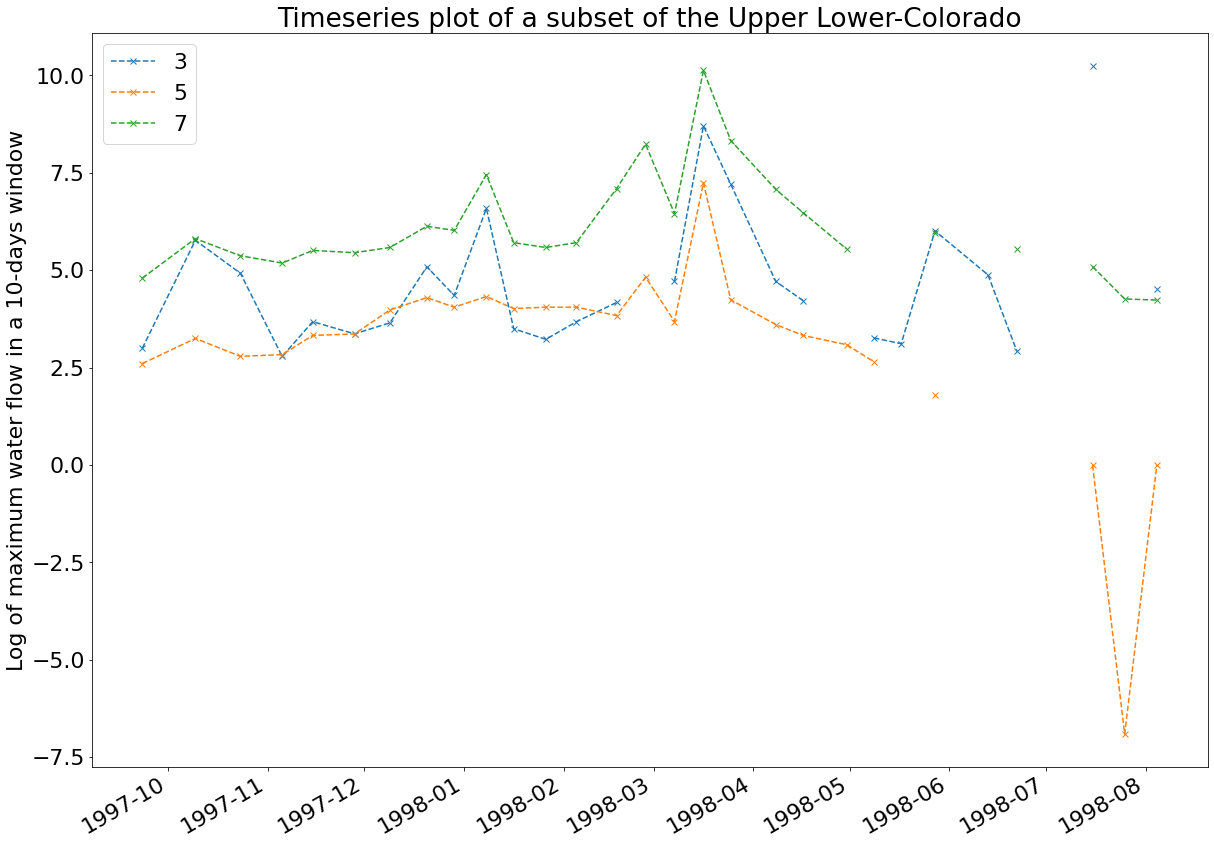

In [261]:
plt.rcParams.update({'font.size': 22})
ax = df[['3','5','7']].iloc[200:230].plot(marker='x',linestyle='--')
ax.set_title('Timeseries plot of a subset of the Upper Lower-Colorado')
ax.set_ylabel('Log of maximum water flow in a 10-days window')
